# 🏠 Malaysia House Price Dataset (Regression)

#Load Dataset

In [102]:
import pandas as pd                                                            
import numpy as np                                                            
import matplotlib.pyplot as plt                                                 
import seaborn as sns       
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression                    
from sklearn.model_selection import train_test_split                            
from sklearn.preprocessing import StandardScaler                                
from sklearn.linear_model import LinearRegression                               
from sklearn.linear_model import Ridge, Lasso, ElasticNet                      
from sklearn.model_selection import GridSearchCV                               
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR 

In [103]:
df = pd.read_csv('malaysia_house_price_data_2025.csv') 
df

,Township,Area,State,Tenure,Type,Median_Price,Median_PSF,Transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800.0,304.0,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900.0,322.0,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954.0,130.0,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600.0,218.0,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300.0,168.0,363
...,...,...,...,...,...,...,...,...
1995,TAMAN ANDALAS JAYA,Klang,Selangor,Freehold,Terrace House,655000.0,410.0,10
1996,TAMAN ANJUNG BERCHAM MEGAH,Ipoh,Perak,Freehold,Terrace House,337500.0,224.0,10
1997,TAMAN PUNCAK JELAPANG MAJU,Ipoh,Perak,Leasehold,"Terrace House, Semi D",290000.0,195.0,10
1998,TAMAN TIONG UNG SIEW,Sibu,Sarawak,Leasehold,Terrace House,480000.0,272.0,10


Data Preprocessing

In [105]:
# Check the shape of the dataset (rows, columns)
data_shape = df.shape

# Check the data types of the columns and the number of non-null values
data_info = df.info()

# Display the first few rows of the dataset to get an idea of the data
data_head = df.head()

data_shape, data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Township      2000 non-null   object 
 1   Area          2000 non-null   object 
 2   State         2000 non-null   object 
 3   Tenure        2000 non-null   object 
 4   Type          2000 non-null   object 
 5   Median_Price  2000 non-null   float64
 6   Median_PSF    2000 non-null   float64
 7   Transactions  2000 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 125.1+ KB


((2000, 8),
 None,
                       Township           Area   State     Tenure  \
 0          SCIENTEX SUNGAI DUA  Tasek Gelugor  Penang   Freehold   
 1                 BANDAR PUTRA          Kulai   Johor   Freehold   
 2  TAMAN LAGENDA TROPIKA TAPAH    Chenderiang   Perak   Freehold   
 3       SCIENTEX JASIN MUTIARA         Bemban  Melaka   Freehold   
 4           TAMAN LAGENDA AMAN          Tapah   Perak  Leasehold   
 
                            Type  Median_Price  Median_PSF  Transactions  
 0                 Terrace House      331800.0       304.0           593  
 1  Cluster House, Terrace House      590900.0       322.0           519  
 2                 Terrace House      229954.0       130.0           414  
 3                 Terrace House      255600.0       218.0           391  
 4                 Terrace House      219300.0       168.0           363  )

In [106]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

Township        0
Area            0
State           0
Tenure          0
Type            0
Median_Price    0
Median_PSF      0
Transactions    0
dtype: int64

In [107]:
df_encoded = pd.get_dummies(df, drop_first=True)
print(f"{df.duplicated().sum()} duplicates found")
df = df.drop_duplicates()
print(f"{df.duplicated().sum()} duplicates remaining after drop")

0 duplicates found
0 duplicates remaining after drop


In [108]:
# Initialize the scaler
scaler = StandardScaler()

# Define the numerical columns to scale
numerical_columns = ['Median_Price', 'Median_PSF', 'Transactions']

# Apply scaling to the numerical columns
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])

# Check the first few rows of the preprocessed data
df_encoded.head()

# Feature Engineering: Create new features
df_encoded['Price_PSF_Interaction'] = df_encoded['Median_Price'] * df_encoded['Median_PSF']  # Interaction term
df_encoded['Log_Transactions'] = np.log1p(df_encoded['Transactions'])  # Log transformation of Transactions

# Check the updated dataframe
df_encoded.head()


,Median_Price,Median_PSF,Transactions,Township_1 TANJUNG,Township_10 Mont Kiara @ MK10,Township_11 Mont Kiara @ MK11,Township_1120 Park Avenue,Township_18 Madge,Township_1Medini,Township_28 Boulevard,...,"Type_Terrace House, Town House",Type_Town House,"Type_Town House, Bungalow","Type_Town House, Bungalow, Terrace House","Type_Town House, Semi D","Type_Town House, Semi D, Terrace House","Type_Town House, Terrace House","Type_Town House, Terrace House, Semi D",Price_PSF_Interaction,Log_Transactions
0,-0.339126,-0.128666,14.987110,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.043634,2.771783
1,0.213898,-0.035514,13.023878,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-0.007596,2.640761
2,-0.556506,-1.029131,10.238212,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.572718,2.419320
3,-0.501767,-0.573723,9.628018,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.287875,2.363494
4,-0.579246,-0.832478,8.885174,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0.482209,2.291036


Exploratory Data Analysis (EDA)

In [110]:
df.describe()

,Median_Price,Median_PSF,Transactions
count,2.000000e+03,2000.000000,2000.000000
mean,4.906854e+05,328.862500,28.091500
std,4.686322e+05,193.281739,37.702385
min,2.704900e+04,38.000000,10.000000
25%,2.699500e+05,201.000000,12.000000
50%,3.900000e+05,293.000000,16.000000
75%,5.735000e+05,412.000000,28.000000
max,1.142050e+07,3017.000000,593.000000


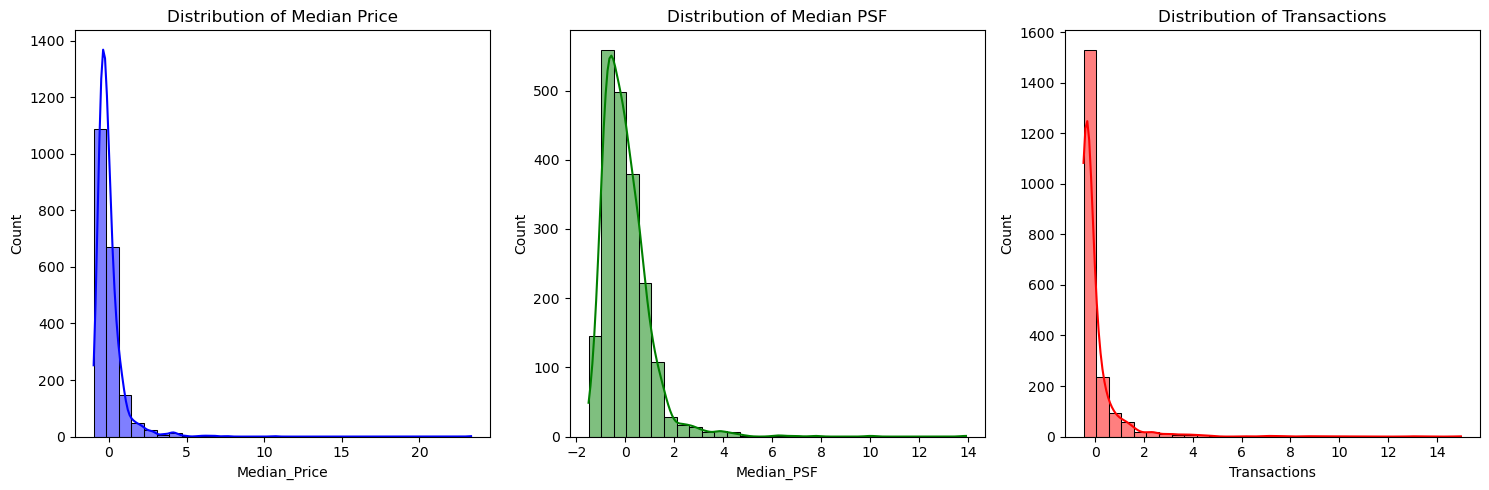

In [111]:
# Set the figure size
plt.figure(figsize=(15, 5))

# Plot the distribution of 'Median_Price'
plt.subplot(1, 3, 1)
sns.histplot(df_encoded['Median_Price'], kde=True, color='blue', bins=30)
plt.title('Distribution of Median Price')

# Plot the distribution of 'Median_PSF'
plt.subplot(1, 3, 2)
sns.histplot(df_encoded['Median_PSF'], kde=True, color='green', bins=30)
plt.title('Distribution of Median PSF')

# Plot the distribution of 'Transactions'
plt.subplot(1, 3, 3)
sns.histplot(df_encoded['Transactions'], kde=True, color='red', bins=30)
plt.title('Distribution of Transactions')

plt.tight_layout()
plt.show()

Correlation Matrix

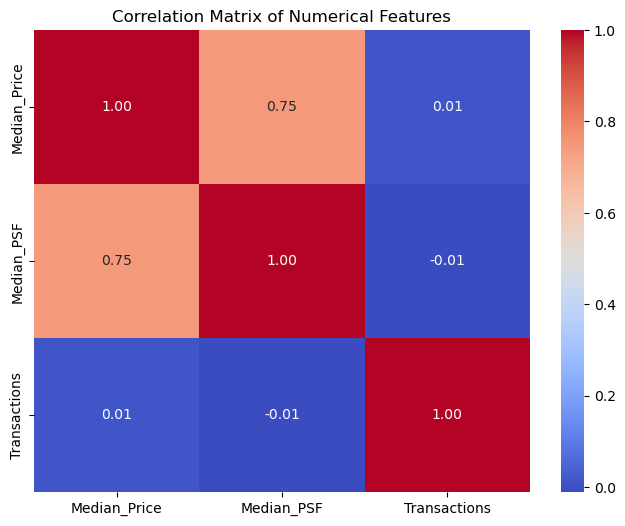

In [113]:
# Calculate the correlation matrix
correlation_matrix = df_encoded[['Median_Price', 'Median_PSF', 'Transactions']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


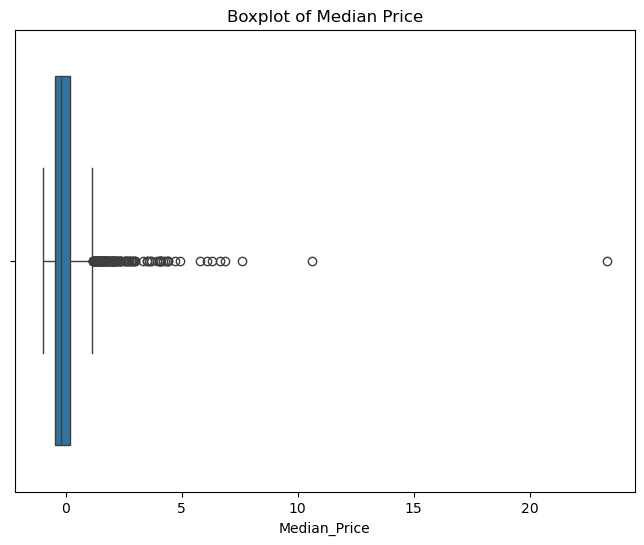

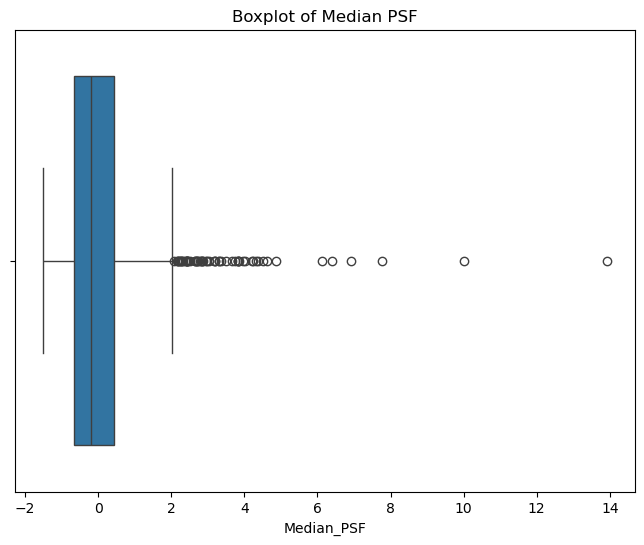

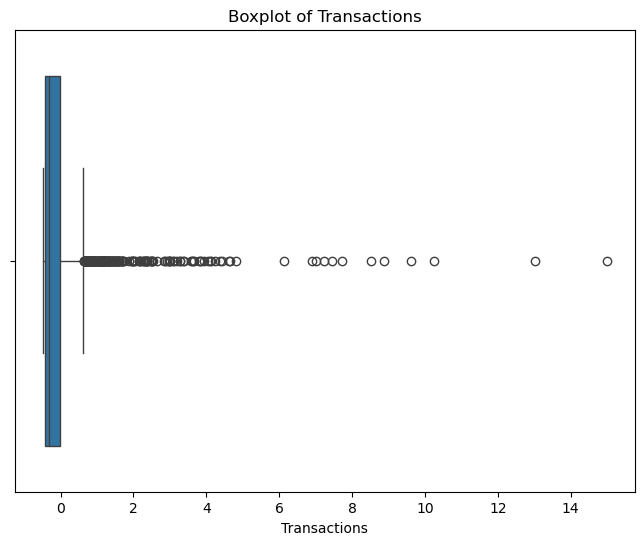

In [114]:
# Boxplot for 'Median_Price'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_encoded['Median_Price'])
plt.title('Boxplot of Median Price')
plt.show()

# Boxplot for 'Median_PSF'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_encoded['Median_PSF'])
plt.title('Boxplot of Median PSF')
plt.show()

# Boxplot for 'Transactions'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_encoded['Transactions'])
plt.title('Boxplot of Transactions')
plt.show()


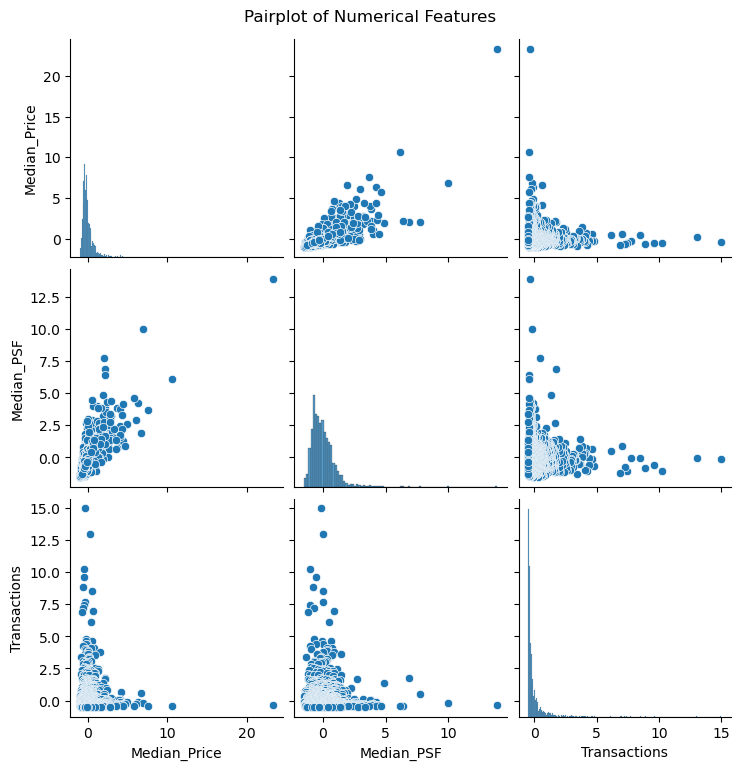

In [115]:
# Pairplot to visualize relationships between features
sns.pairplot(df_encoded[['Median_Price', 'Median_PSF', 'Transactions']])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()


In [116]:
# Define features (X) and target (y)
X = df_encoded.drop(columns='Median_Price')  # Remove the target column
y = df_encoded['Median_Price']  # The target variable

# Display the first few rows of features (X) and target (y)
X.head(), y.head()


(   Median_PSF  Transactions  Township_1 TANJUNG  \
 0   -0.128666     14.987110               False   
 1   -0.035514     13.023878               False   
 2   -1.029131     10.238212               False   
 3   -0.573723      9.628018               False   
 4   -0.832478      8.885174               False   
 
    Township_10 Mont Kiara @ MK10  Township_11 Mont Kiara @ MK11  \
 0                          False                          False   
 1                          False                          False   
 2                          False                          False   
 3                          False                          False   
 4                          False                          False   
 
    Township_1120 Park Avenue  Township_18 Madge  Township_1Medini  \
 0                      False              False             False   
 1                      False              False             False   
 2                      False              False             False

In [117]:
# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600, 2314) (400, 2314) (1600,) (400,)


In [118]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [119]:
#normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [120]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R² Score
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'R² Score: {r2}')


Mean Squared Error (MSE): 0.3365081279507413
R² Score: 0.5801161246007651


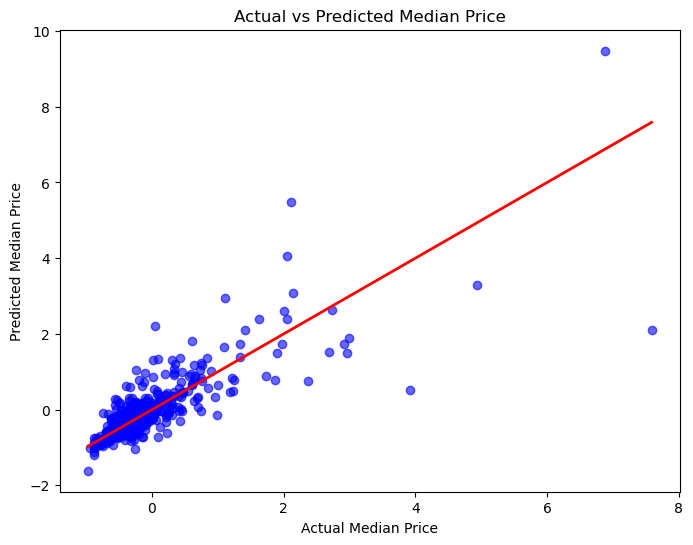

In [121]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)  # Diagonal line (perfect prediction)
plt.xlabel('Actual Median Price')
plt.ylabel('Predicted Median Price')
plt.title('Actual vs Predicted Median Price')
plt.show()

Model Tuning

L1 Regularization(Lasso)

Lasso regression applies L1 regularization that penalizes the absolute size of the coefficients. This can shrink some coefficients to zero, effectively performing feature selection.

In [125]:
# Initialize the Lasso (L1 Regularization) model
lasso = Lasso(alpha=0.1)  # alpha controls the strength of regularization

# Train the model
lasso.fit(X_train, y_train)

# Make predictions
y_pred_lasso = lasso.predict(X_test)

# Evaluate the model
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Lasso (L1 Regularization) - MSE: {mse_lasso}, R²: {r2_lasso}')


Lasso (L1 Regularization) - MSE: 0.3106920320364683, R²: 0.6123286077469376


L2 Regularization(Ridge)

Ridge regression applies L2 regularization that penalizes the square of the coefficients. It doesn’t shrink coefficients to zero but rather penalizes large coefficients to avoid overfitting.

In [128]:
from sklearn.linear_model import Ridge

# Initialize the Ridge (L2 Regularization) model
ridge = Ridge(alpha=0.1)  # alpha controls the strength of regularization

# Train the model
ridge.fit(X_train, y_train)

# Make predictions
y_pred_ridge = ridge.predict(X_test)

# Evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge (L2 Regularization) - MSE: {mse_ridge}, R²: {r2_ridge}')


Ridge (L2 Regularization) - MSE: 0.3133200695414885, R²: 0.6090494281948052


L1 + L2 Regularization (ElasticNet)

ElasticNet combines both L1 and L2 regularization, which allows for both feature selection and coefficient shrinkage.

In [131]:
# Initialize the ElasticNet model (L1+L2 Regularization)
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha is the regularization strength, l1_ratio controls the mix between L1 and L2

# Train the model
elasticnet_model.fit(X_train, y_train)

# Predict on the test data
y_pred_elasticnet = elasticnet_model.predict(X_test)

# Evaluate the model
mse_elasticnet = mean_squared_error(y_test, y_pred_elasticnet)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)

print(f'ElasticNet Mean Squared Error: {mse_elasticnet}')
print(f'ElasticNet R² Score: {r2_elasticnet}')


ElasticNet Mean Squared Error: 0.316771318762809
ElasticNet R² Score: 0.6047430718911952


In [132]:
# calculate accuracy
accuracy_l1l2 = elasticnet_model.score(X_test, y_test) * 100
print(f'Accuracy: {accuracy_l1l2}')

Accuracy: 60.47430718911953


XGBoost (Extreme Gradient Boosting)

XGBoost is an ensemble learning algorithm based on gradient boosting. It is known for its high accuracy, efficiency, and speed, especially in handling non-linear relationships and large datasets.

In [135]:
# Clean up column names to ensure they’re strings without invalid characters
X_train.columns = X_train.columns.astype(str).str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test.columns = X_test.columns.astype(str).str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # For regression tasks
    'eval_metric': 'rmse',            # Root Mean Squared Error as evaluation metric
    'eta': 0.1,                       # Learning rate
    'max_depth': 6,                    # Max depth of tree
    'subsample': 0.8,                  # Subsampling ratio
    'colsample_bytree': 0.8,           # Subsample ratio of columns
    'lambda': 1.0,                     # L2 regularization term
    'alpha': 0.0,                      # L1 regularization term
}

# Train the XGBoost model
xgboost_model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_pred_xgb = xgboost_model.predict(dtest)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost R² Score: {r2_xgb}')


XGBoost Mean Squared Error: 0.08973724513239369
XGBoost R² Score: 0.8880287900227001


Evaluation Metrics of Linear Regression and Random Forest

In [154]:
models = {
    'Linear Regression': LinearRegression(),
    'Lasso (L1 Regularization)': Lasso(alpha=0.1),
    'Ridge (L2 Regularization)': Ridge(alpha=0.1),
    'ElasticNet (L1+L2 Regularization)': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse',
                                eta=0.1, max_depth=6, subsample=0.8,
                                colsample_bytree=0.8, reg_lambda=1.0, alpha=0.0)
}

# Initialize empty dictionary to store metrics
metrics = {}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    metrics[name] = [mae, mse, rmse, r2]

results = pd.DataFrame(metrics, index=['MAE', 'MSE', 'RMSE', 'R² Score']).T
results = results.round(4)
print(results)

                                      MAE     MSE    RMSE  R² Score
Linear Regression                  0.3279  0.3365  0.5801    0.5801
Lasso (L1 Regularization)          0.3375  0.3107  0.5574    0.6123
Ridge (L2 Regularization)          0.2915  0.3133  0.5598    0.6090
ElasticNet (L1+L2 Regularization)  0.3349  0.3168  0.5628    0.6047
XGBoost                            0.1157  0.0897  0.2996    0.8880


Comparison between Acccuracies of Linear Regression and XGBoost

Comparison of Accuracy Between Linear Regression & XGBoost

In [146]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso (L1 Regularization)': Lasso(alpha=0.1),
    'Ridge (L2 Regularization)': Ridge(alpha=0.1),
    'ElasticNet (L1+L2 Regularization)': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'XGBoost': xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        eta=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        alpha=0.0
    )
}

# Store accuracies
accuracies = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    accuracy = r2 * 100  # Convert to percentage
    accuracies[name] = accuracy

# Create and display DataFrame
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy (%)'])
accuracy_df = accuracy_df.sort_values(by='Accuracy (%)', ascending=False).reset_index(drop=True)

print("\nModel Accuracy Comparison:\n")
print(accuracy_df.to_string(index=False))



Model Accuracy Comparison:

                            Model  Accuracy (%)
                          XGBoost     88.802879
        Lasso (L1 Regularization)     61.232861
        Ridge (L2 Regularization)     60.904943
ElasticNet (L1+L2 Regularization)     60.474307
                Linear Regression     58.011612
